Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
data_dir_test = pathlib.Path('CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split =0.2,
    subset = "training",
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "validation",
    seed =123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

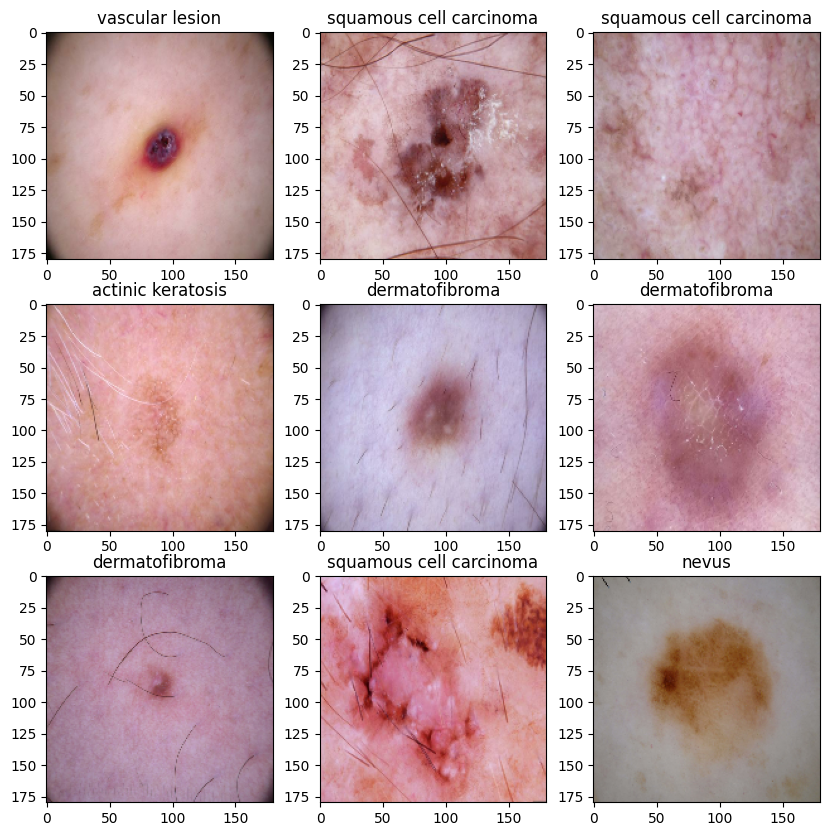

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(class_names[labels[i]])
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Dropout

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

input_shape = (180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Train the model

In [43]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


394/394 [==============================] - 33s 84ms/step - loss: 0.5029 - accuracy: 0.8069 - val_loss: 0.6886 - val_accuracy: 0.7541
Epoch 2/20
394/394 [==============================] - 34s 85ms/step - loss: 0.4796 - accuracy: 0.8160 - val_loss: 0.6643 - val_accuracy: 0.7649
Epoch 3/20
394/394 [==============================] - 33s 84ms/step - loss: 0.4798 - accuracy: 0.8154 - val_loss: 0.6564 - val_accuracy: 0.7690
Epoch 4/20
394/394 [==============================] - 34s 85ms/step - loss: 0.5145 - accuracy: 0.8040 - val_loss: 0.5999 - val_accuracy: 0.7919
Epoch 5/20
394/394 [==============================] - 34s 85ms/step - loss: 0.4916 - accuracy: 0.8114 - val_loss: 0.6134 - val_accuracy: 0.7776
Epoch 6/20
394/394 [==============================] - 33s 84ms/step - loss: 0.4933 - accuracy: 0.8130 - val_loss: 0.6602 - val_accuracy: 0.7671
Epoch 7/20
394/394 [==============================] - 33s 84ms/step - loss: 0.4790 - accuracy: 0.8188 - val_loss: 0.6986 - val_accuracy: 0.7588
Epo

### Visualizing training results

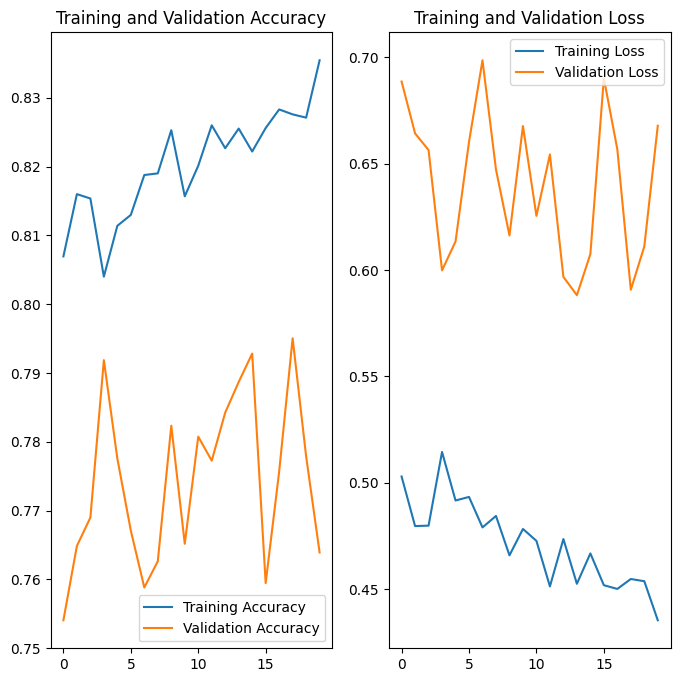

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3))  
])

1. Model has overfitting issue with training data having 75% accuracy and validatiion data having accuracy ~ 55%
2. The loss decreases for each epoch, but the case is opposite with validation set

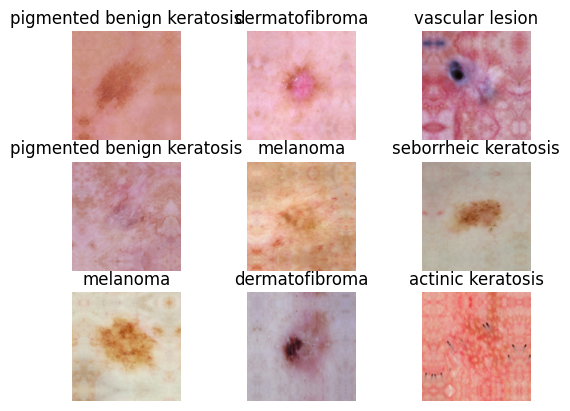

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
for img, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(data_augmentation(img)[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])


### Compiling the model

In [22]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history20 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) 

Epoch 1/20
281/281 [==============================] - 37s 129ms/step - loss: 1.7873 - accuracy: 0.3020 - val_loss: 1.4840 - val_accuracy: 0.3832
Epoch 2/20
281/281 [==============================] - 46s 164ms/step - loss: 1.4533 - accuracy: 0.4356 - val_loss: 1.4271 - val_accuracy: 0.4522
Epoch 3/20
281/281 [==============================] - 21s 76ms/step - loss: 1.3878 - accuracy: 0.4621 - val_loss: 1.2960 - val_accuracy: 0.4953
Epoch 4/20
281/281 [==============================] - 22s 77ms/step - loss: 1.3381 - accuracy: 0.4741 - val_loss: 1.2851 - val_accuracy: 0.4900
Epoch 5/20
281/281 [==============================] - 22s 77ms/step - loss: 1.2859 - accuracy: 0.4891 - val_loss: 1.2592 - val_accuracy: 0.5082
Epoch 6/20
281/281 [==============================] - 22s 77ms/step - loss: 1.2592 - accuracy: 0.5007 - val_loss: 1.2717 - val_accuracy: 0.5051
Epoch 7/20
281/281 [==============================] - 22s 77ms/step - loss: 1.2229 - accuracy: 0.5150 - val_loss: 1.2418 - val_accurac

### Visualizing the results

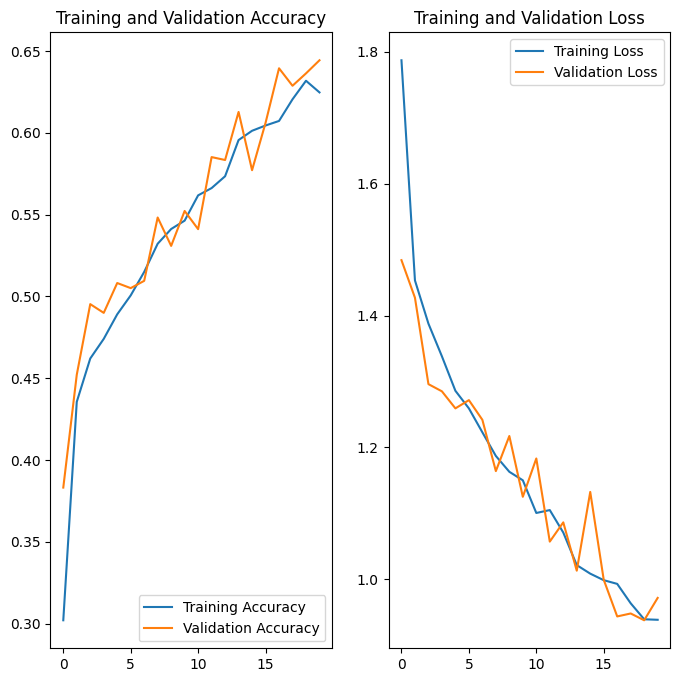

In [24]:
acc = history20.history['accuracy']
val_acc = history20.history['val_accuracy']

loss = history20.history['loss']
val_loss = history20.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

The accuracy of the model has greatly increased along with the synchronization of the verification accuracy. 
The loss function moves down for each epoch for the training and validation data.

In [25]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
1,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
2,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
3,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
4,CNN_assignment\Skin cancer ISIC The Internatio...,actinic keratosis
...,...,...
2234,CNN_assignment\Skin cancer ISIC The Internatio...,vascular lesion
2235,CNN_assignment\Skin cancer ISIC The Internatio...,vascular lesion
2236,CNN_assignment\Skin cancer ISIC The Internatio...,vascular lesion
2237,CNN_assignment\Skin cancer ISIC The Internatio...,vascular lesion


<BarContainer object of 9 artists>

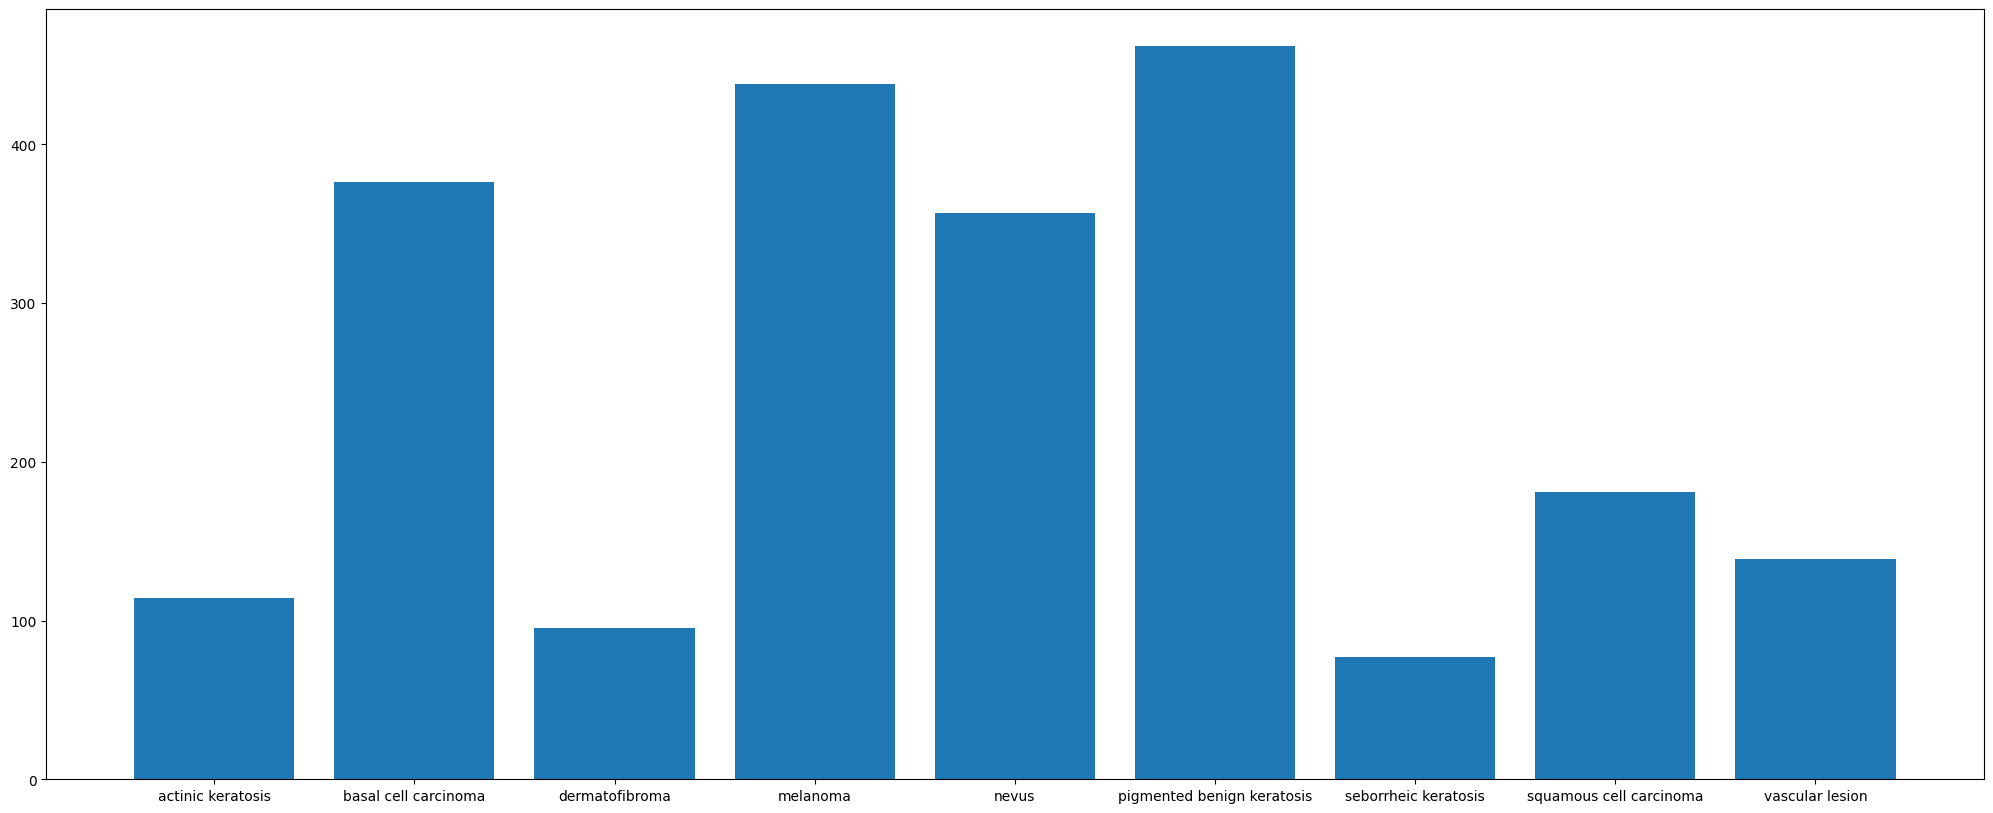

In [26]:
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Seborrheic keratosis has least number of samples

pigmented beningn keratosis, melanoma, basal cell carcioma and nevus dominate data with big number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset="CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2242E3C9190>: 100%|██████████| 500/500 [00:01<00:00, 479.62 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x226813C5350>: 100%|██████████| 500/500 [00:01<00:00, 468.29 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2242E694210>: 100%|██████████| 500/500 [00:00<00:00, 545.69 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x226813D6690>: 100%|██████████| 500/500 [00:04<00:00, 116.23 Samples/s]                    


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x2242E697810>: 100%|██████████| 500/500 [00:04<00:00, 111.52 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2244369A610>: 100%|██████████| 500/500 [00:00<00:00, 503.57 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x22443691F10>: 100%|██████████| 500/500 [00:01<00:00, 251.34 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2242E60F190>: 100%|██████████| 500/500 [00:01<00:00, 407.36 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2243E0B16D0>: 100%|██████████| 500/500 [00:01<00:00, 476.73 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_233ad74f-59a2-4d17-9e10-5867b20506dd.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2b776c1a-e7dc-42c6-85aa-626afefcce32.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_8156e0df-2d35-4162-b9dd-5d13a66b8d3d.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9659574b-a440-4be7-9871-273273942af7.jpg',
 'CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9fd406ba-ba3b-4d27-9f08-fe02710c5

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df + df2

In [34]:
new_df['Label'].value_counts()

Label
melanomaactinic keratosis                         438
basal cell carcinomaactinic keratosis             376
nevusactinic keratosis                            357
pigmented benign keratosisbasal cell carcinoma    342
squamous cell carcinomabasal cell carcinoma       181
vascular lesionbasal cell carcinoma               139
pigmented benign keratosisactinic keratosis       120
actinic keratosisactinic keratosis                114
dermatofibromaactinic keratosis                    95
seborrheic keratosisbasal cell carcinoma           77
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train="CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
## your code goes here
num_classes = 9
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [41]:
epochs = 50
## Your code goes here, use 50 epochs.
history50 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


394/394 [==============================] - 34s 84ms/step - loss: 1.7241 - accuracy: 0.3316 - val_loss: 1.4128 - val_accuracy: 0.4646
Epoch 2/50
394/394 [==============================] - 35s 89ms/step - loss: 1.3917 - accuracy: 0.4523 - val_loss: 1.3693 - val_accuracy: 0.4700
Epoch 3/50
394/394 [==============================] - 34s 85ms/step - loss: 1.2922 - accuracy: 0.4878 - val_loss: 1.2705 - val_accuracy: 0.5087
Epoch 4/50
394/394 [==============================] - 33s 84ms/step - loss: 1.2428 - accuracy: 0.5152 - val_loss: 1.2640 - val_accuracy: 0.5272
Epoch 5/50
394/394 [==============================] - 33s 84ms/step - loss: 1.1951 - accuracy: 0.5369 - val_loss: 1.1322 - val_accuracy: 0.5720
Epoch 6/50
394/394 [==============================] - 33s 84ms/step - loss: 1.1339 - accuracy: 0.5565 - val_loss: 1.1799 - val_accuracy: 0.5542
Epoch 7/50
394/394 [==============================] - 33s 84ms/step - loss: 1.0955 - accuracy: 0.5703 - val_loss: 1.0735 - val_accuracy: 0.5955
Epo

#### **Todo:**  Visualize the model results

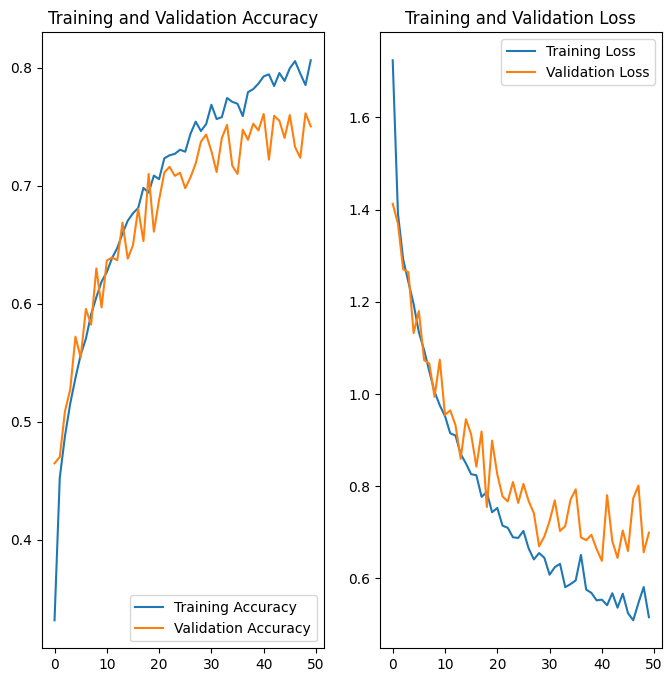

In [42]:
acc = history50.history['accuracy']
val_acc = history50.history['val_accuracy']

loss = history50.history['loss']
val_loss = history50.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes, the fiting issues are resolved to large extent. With increased Epochs value the accuracy with Training and validation is ranging from 75% to 80% respectively. 
The loss also mitigated with increase in epochs